# Introduction to Python - Numpy
## Problem Set

In [22]:
# Author: Alex Schmitt (schmitt@ifo.de)

import datetime
print('Last update: ' + str(datetime.datetime.today()))

Last update: 2017-05-07 20:48:37.847497


### Exercise 1

Consider the polynomial expression
\begin{equation*}
	p(x) = a_0 + a_1 x + a_2 x^2 + \cdots + a_N x^N = \sum_{n=0}^N a_n x^n,
\end{equation*}
where $x$ is a scalar number.

(a) Write a Python function **poly(x, coeff)** that implements $p(x)$ (i.e. evaluates the polynomial) given a point **x** and a list of coefficients **coeff** ($= a_0,...,a_N$). Use a loop with **enumerate()**.

(b) Write a new function **poly_np(x, coeff)** that does the same job, but uses NumPy arrays and vectorized operations, rather than any form of Python loop. Hint: Use **np.cumprod()**.

(C) Using **%time**, check how long it takes for both functions to run when **len(coeff)** = 50 (you can use arbitrary values for the elements in **coeff**).


#### (a)

As an example, let's compute $p(x) = 1 + x^2 + x^4$ at $x = 2$, which gives $p(2) = 21$. Using **enumerate()**, the loop is straightforward:

In [8]:
def poly(x, coeff):
    # initialize s as 0
    s = 0
    for (i, a) in enumerate(coeff):
        # for each iteration, add the corresponding term to s
        s = s + a * x**i
        
    return s

poly(2, [1, 2, 4])

21

Note that we can implement the exact same algorithm in one line:

In [40]:
# def poly(x, coeff):
#     return sum(a * x**i for i, a in enumerate(coeff))

# poly(2, [1, 2, 4])

#### (b) 

Using **np.cumprod()** on a sequence gives an array where at each position, you have the product of all elements that come before or at that position in the original array. For example, **np.cumprod([2,3,4,5])** would return **[2,6,24,120]** as a NP array. For the function here, we need to apply **np.cumprod()** on an array **[1, x, x, x, ..]**, which would return **[1, x, x^2, x^3,...]**. We can use the inner product of this array and **coeff**.

In [9]:
def poly_np(x, coeff):
    # define X = [1 x x ...]
    X = np.empty(len(coeff))
    X[0] = 1
    X[1:] = x
    # using cumprod on X gives [1 x x^2 x^3 ...]
    y = np.cumprod(X)
    # compute and return inner product
    return coeff @ y

poly_np(2, [1, 2, 4])

21.0

As an alternative, note that a vectorized operations also works if *the array is in the exponent*. In other words, implementing something like $x^{(0,1,2)}$ in Python, where $x$ is a scalar, would give $(x^0, x^1, x^2)$. Again, this works only if the sequence $(0,1,2)$ is a NumPy array. 

In [13]:
def poly_np2(x, coeff):
    return coeff @ x**np.linspace(0,len(coeff)-1,len(coeff))

poly_np2(2, [1, 2, 4])

21.0

#### (c) 

In [14]:
# use random module to assign arbitrary values to coeff
N = 50000
coeff = np.random.uniform(0, 1, N)
x = 0.1

With **len(coeff) = 50**, the running times across all functions are very small and close to each other. Instead, let's increase the number of elements in **coeff** to 50000. There are notable differences in the running times across the functions, with the **poly_np** function using **np.cumprod()** being by far the fastest - the difference compared to the loop-implementation in Vanilla Python is a factor of about 30 -- another example for the speed of vectorized operations.

In [15]:
%time print(poly(x, coeff))
%time print(poly_np(x, coeff))
%time print(poly_np2(x, coeff))

0.201990823858
CPU times: user 25 ms, sys: 321 µs, total: 25.4 ms
Wall time: 25.1 ms
0.201990823858
CPU times: user 861 µs, sys: 204 µs, total: 1.06 ms
Wall time: 576 µs
0.201990823858
CPU times: user 12.3 ms, sys: 471 µs, total: 12.7 ms
Wall time: 3.08 ms


### Exercise 2



## Question 2

Compute an approximation to $\pi$ with the Monte Carlo method using **Numpy**. Your hints are as follows:
- If $U$ is a bivariate uniform random variable on the unit square $(0,1)^2$, then the probability that $U$ lies in a subset $B$ of $(0,1)^2$ is equal to the area of $B$.
- If $U_1,...,U_n$ are iid copies of $U$, then, as $n$ gets large, the fraction that fall in $B$ converges to the probability of landing in $B$
- Recall that for a circle, $area = \pi * radius^2$

(Source: lectures.quantecon.org, An Introductory Example, Exercise 3)

In [2]:
import numpy as np

# function throws gives the fraction of throws that land in the unit cycle 
# 	= area of unit cycle 
def area(n):
    count = 0
    for i in range(n):
        x, y = np.random.uniform(0,1), np.random.uniform(0,1) # x-coordinate, y-coordinate
        if np.sqrt((x - 0.5)**2 + (y - 0.5)**2) <= 0.5:
            count += 1
    return count/n

pi = area(100000) / 0.5**2;
print(pi)
## for comparison
print(np.pi)


3.1494
3.141592653589793


## Exercise 3

In this question, you are asked to write your own implementation of the *bisection method* to compute the root of a real-valued function. Of course, most programming languages already have in-built implementations (e.g. in SciPy: **scipy.optimize.bisect**}, so writing your own function may seem a bit redundant. The goal here is to give you some idea about the inner workings of many of the algorithms used in scientific computing. The bisection method, while quite simple, captures two important features of most root-finding and optimization methods: it is a *local* method and it is based on an *iterative procedure*. 

- Recall that a root of a real-valued function $f$ is a value $x$ in the domain of the function such that $f(x)=0$. The idea behind the bisection method is based on the *Intermediate Value Theorem*: if $f$ is continuous and defined on the interval $[a,b]$, and if $f(a)$ and $f(b)$ are distinct values, then $f$ must assume all values in between. Since we are interested in where $f$ assumes the value 0, we need $f(a)$ and $f(b)$ to have different signs.
- The bisection method implements the following "pseudo-code":

(i) Start with two values $a$ and $b$ such that $f(a)$ and $f(b)$ are defined and have different signs. Moreover, specify a "tolerance level" $tol$ which should be a very small number, e.g. 1e-8.

(ii) Compute the midpoint between $a$ and $b$, $x = \frac{a + b}{2}$. 

(iii) If $f(x)$ has the same sign as $f(a)$, replace the left endpoint of the interval with $x$, i.e. $a = x$.

(iv) If $f(x)$ has the same sign as $f(b)$, replace the right endpoint of the interval with $x$, i.e. $b = x$.

(v) Repeat from (ii) until the absolute value of $f(x)$ is less than $tol$, i.e. $|f(x)| < tol$.

- Bisection is an *iterative procedure*: at the beginning of each iteration step, the interval $[a,b]$ contains a root of $f$. The interval is then divided ("bisected") into two subintervals of equal length. One of the two subintervals must contain the root, and hence have endpoints of different signs. This subinterval is taken as the interval $[a,b]$ used for the next iteration. This process continues until the resulting midpoint $x$ of the current interval is sufficiently close to 0.  
- Moreover, note that bisection is a *local* method: it will not give you all the roots of a function, but only one of the roots (in case there are multiple roots) between $a$ and $b$. A corollary of this is that the outcome of bisection (and of local methods in general) is sensitive to the starting point chosen by the user, here the values for $a$ and $b$.

Write a function **mybisect(f, a, b)** in Python that implements the pseudo-code above. Then, test it on the function 
\begin{equation*}
    f(x) = \sin(4 (x - 1/4)) + x + x^{20} - 1,
\end{equation*}
i.e. find a root of this function. Compare your result to what SciPy's in-built function returns. 

*Hint*: most modern programming languages have some type of **while**-loop, which will prove useful here. Moreover, in Python/NumPy, consider using the **abs()** and **np.sign()** functions.  



In [43]:
# function to use bisection on
def fun(x):
    return np.sin(4 * (x - 0.25)) + x + x**20 - 1


def mybisect(fun, a, b):
    """
    Implements the bisection method
    """
    # choose tolerance level
    tol = 1e-10
    # initialize d 
    d = 1
    # while-loop: iterate until d sufficiently small
    while abs(d) > tol:
        # find intermediate value between a and b
        x = (a + b)/2
        # evaluate function
        d = fun(x)
        # find new end points for interval [a,b]
        if np.sign(d) == np.sign(fun(a)):
            a = x
        elif np.sign(d) == np.sign(fun(b)):
            b = x
    
    return x

print(mybisect(fun,0,2))        

0.408293504267931


In [42]:
import scipy.optimize
print(scipy.optimize.bisect(fun,0,2))

0.4082935042806639


## Question 4

In this question, we are going to go through a very simple implementation of dynamic programming in Python. If you have never heard of dynamic programming before, don't worry - just follow along the instructions. 

As an application, recall the standard neoclassical growth model (Ramsey model) from your Macro classes. Suppose a social planner maximizes lieftime utility of a infinitely-lived, representative household: 
\begin{equation}
    \max \sum^\infty_{t = 0} \beta^t u(c_t) 
\end{equation}
s.t. 
\begin{equation}
    k_{t+1} + c_t = f(k_t) + (1 - \delta) k_t = k_t^\alpha + (1 - \delta) k_t. 
\end{equation}
In words, there is a single consumption good, which is produced using a single production factor, capital $k_t$, which is accumulated over time. $f$ denotes the production function, while $u$ denotes the utility function. To make things even more simple, assume that $u(c) = \log(c)$ and $\delta = 1$ (i.e. capital fully depreciates between two periods). 

Hence, we can write the planner's maximization problem more compactly in the following way: 
\begin{equation}
    \max_{k_{t+1}} \sum^\infty_{t = 0} \beta^t \log(k_t^\alpha - k_{t+1}). 
\end{equation}
This is an intertemporal optimization problem. Under the particular assumptions made here, we can find an analytical solution. The optimal investment decision of the planner is given by:
\begin{equation}
    k_{t+1} = \alpha \beta k_t^\alpha,\ c_t = (1 - \alpha \beta) k_t^\alpha.
\end{equation}
In other words, in every period a constant share $\alpha \beta$ of output is "saved", while the remaining share is consumed. 

The goal of this question is to find the same "policy function" numerically. As a side note, the strategy used below works for other functional forms and less-than-full depreciation. 

(a) Start by writing two short Python function - **utility** and **prod** - that both take a single argument and implement the utility function and the production function given above. Note that they should work on both scalar values and Numpy arrays. 

In [3]:
## question (a)
import numpy as np

def utility(c):
    return np.log(c)

def prod(k):
    return k**alpha

(b) Next, we define a "grid" for the capital stock, i.e. an array of possible values that $k_t$ can take. Of course, the capital stock in this model is a *continuous* variable. However, we cannot really express continuous variables (with infinitely many values) on a computer, so we need to *discretize* it.

For this, assume that the capital stock always lies between two values, **k_min** and **k_max** (In other words, if the capital stock in period 0 is between these two values, it will not go outside of the interval, assuming that the planner behaves optimally). Of course, these bounds depend on the parameter values for **alpha** and **beta**. Set **alpha** to 0.33 and **beta** to 0.95. Then, **k_min = 0.05** and **k_max = 0.25** will do the trick. Use the Numpy's **linspace** function to create an array **k_grid** with **N** values for capital between these two bounds. For now, set **N = 100**.

In [14]:
## question (b)

alpha = 0.33
beta = 0.95

## steady state (not part of the question)
ks = (alpha * beta)**(1 / (1 - alpha))
print(ks)

## define grid for capital
k_min = 0.05
k_max = 0.25
N = 100
k_grid = np.linspace(k_min, k_max, N)

0.17705807534879062


(c) The key insight of dynamic programming is the *Bellman equation*. In terms of the model above, it states that the following equation must hold for any (feasible) $k_t$:
\begin{equation}
    v(k_t) = \max_{k_{t+1}} \log(k_t^alpha - k_{t+1}) + \beta v(k_{t+1})  
\end{equation}
$v$ is called the *value function*. To keep the question reasonably short, we skip the intuition behind this equation. 

We use the idea of the Bellman equation in a simple algorithm called *value function iteration* (again, we omit the discussion why this works, just believe us:). The main steps are the following.
1. Start with an initial guess for the value function, $v^0$. For simplicity, we're going to use $v^0(k) = 0$ for all $k$.
2. Given your current guess $v^n$ for the value function, solve the maximization on the right hand side of the value function and call it $v^{n+1}$:
\begin{equation}
    v^{n+1}(k_t) = \max_{k_{t+1}} \log(k_t^alpha - k_{t+1}) + \beta v^{n}(k_t)  
\end{equation}
3. Check if $v^{n+1}$ is sufficiently close to $v^n$ (more on this below). If not, use as your current guess and go back to 2. and repeat. If $v^{n+1} \approx v^n$, you have found an approximation of the "true" value function $v^* = v^{n+1}$.

The beauty of this algorithm is that it is guarantueed to converge (given that some conditions are satisfied, which they are here), i.e. *no matter your initial guess for the value function, you will always find a $v^{*}$* (and the algorithm will stop at $v^*$).

The above algorithm can be implemented numerically in many different ways, some better than others. One apect that distinguishes different methods is how to represent a function $v$ numerically. Here, in the simplest possible implementation, we represent $v$ as a numpy array. In other words, the $i$th element of the array **v** is given by:
\begin{equation}
    \mathbf{v}_i = \max_{x \in \mathbf{kgrid}} \log(\mathbf{k}_i - x) + \beta \mathbf{v}^{old}_i  
\end{equation}


In [21]:
v_old = np.zeros(N)

eps = 1
tol = 1e-8
it = 0
while eps > tol:
    it += 1
    v = np.zeros(N)
    for (ind, item) in enumerate(k_grid):
        v[ind] = np.max( utility(prod(item) - k_grid) + beta * v_old ) 
        
    eps = np.linalg.norm(v_old - v)
    v_old = v.copy()


In [19]:
## question (d)
k_pol = np.zeros(N)
for (ind, item) in enumerate(k_grid):
    max_ind = np.argmax( utility(prod(item) - k_grid) + beta * v)  
    k_pol[ind] = k_grid[max_ind]   
    

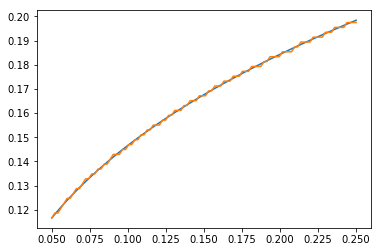

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.plot(k_grid, alpha * beta * prod(k_grid))
ax.plot(k_grid, k_pol)